In [2]:
import cv2
import numpy as np
from ultralytics import YOLO
import os

# Optional: for displaying images/videos directly in the notebook output
from IPython.display import display, Image, clear_output 
import time # To add slight delay in display loop if needed
import random # For generating random colors for tracks

## 1. Camera Calibration (Placeholder)

We need the camera intrinsic matrix K for 3D backprojection later. Since we don't have the exact parameters, we'll define a placeholder `K` after loading the video, based on its dimensions. We make rough assumptions (e.g., focal length related to image width, principal point at the center).

**Assumption:** These values must be replaced with actual calibration data for accurate results.

In [3]:
# Placeholder for Camera Calibration Matrix K
# We'll define this properly once we load the video and get its dimensions.
K = None 
print("Camera Matrix K will be defined after loading the video.")

Camera Matrix K will be defined after loading the video.


## 2. Feature Detection (YOLOv8)

We'll use a pre-trained YOLOv8 model to detect vehicles (cars, buses, trucks) in the video frames.

In [4]:
# Load the YOLOv8 model (e.g., 'yolov8n.pt' for the nano version)
# Ensure the model file is available. Ultralytics usually downloads it automatically 
# the first time, but you might need internet access.
try:
    model = YOLO('yolov8n.pt')
    print("YOLOv8 model loaded successfully.")
except Exception as e:
    print(f"Error loading YOLO model: {e}")
    print("Make sure 'yolov8n.pt' can be downloaded or specify the correct path if stored locally.")
    model = None # Ensure model is None if loading failed

YOLOv8 model loaded successfully.


In [16]:

# Make sure YOLO is imported earlier in the notebook
# from ultralytics import YOLO

def detect_vehicle_features(frame, yolo_model):
    """Detects vehicles using YOLO and extracts Shi-Tomasi corners as features.

    Args:
        frame: The input video frame (NumPy array).
        yolo_model: The loaded YOLO model.

    Returns:
        A tuple containing:
        - vehicle_boxes: List of bounding boxes [xmin, ymin, xmax, ymax] for detected vehicles.
        - feature_points_list: List of lists. Each inner list contains Shi-Tomasi corner points
                               (as NumPy arrays) detected within the corresponding vehicle box.
    """
    if yolo_model is None:
        return [], []

    # --- Parameters for Shi-Tomasi ---
    # Adjust these parameters as needed
    max_corners = 20       # Maximum number of corners to return per vehicle.
    quality_level = 0.05   # Minimal accepted quality of image corners (0.01-0.1).
    min_distance = 10      # Minimum possible Euclidean distance between the returned corners.
    block_size = 7         # Size of an average block for computing a derivative covariation matrix over each pixel neighborhood.
    # ----------------------------------

    # Run YOLO inference
    results = yolo_model(frame, verbose=False, classes=[2, 5, 7], conf=0.3) # car, bus, truck

    vehicle_boxes = []
    feature_points_list = []

    if results:
      processed_results = results[0] # Access the Results object
      boxes = processed_results.boxes  # Boxes object

      for box in boxes:
          xyxy = box.xyxy[0].cpu().numpy().astype(int) # Get coordinates [xmin, ymin, xmax, ymax]
          vehicle_boxes.append(xyxy)

          # --- Shi-Tomasi Feature Detection within ROI ---
          xmin, ymin, xmax, ymax = xyxy

          # Ensure ROI coordinates are valid and have some area
          if xmax > xmin and ymax > ymin:
              # Extract Region of Interest (ROI)
              roi = frame[ymin:ymax, xmin:xmax]

              # Convert ROI to grayscale (goodFeaturesToTrack works on grayscale)
              gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

              # Detect corners using Shi-Tomasi
              corners = cv2.goodFeaturesToTrack(
                  gray_roi,
                  maxCorners=max_corners,
                  qualityLevel=quality_level,
                  minDistance=min_distance,
                  blockSize=block_size
              )

              current_vehicle_features = []
              if corners is not None:
                  # Corners are relative to the ROI, shift them to be relative to the full frame
                  for i in range(corners.shape[0]):
                      pt_x = int(corners[i, 0, 0] + xmin)
                      pt_y = int(corners[i, 0, 1] + ymin)
                      current_vehicle_features.append(np.array([pt_x, pt_y], dtype=np.float32)) # Store as float32 for KLT later

              feature_points_list.append(current_vehicle_features)
          else:
              # If ROI is invalid, add an empty list for this vehicle
              feature_points_list.append([])
          # -----------------------------------------------

    return vehicle_boxes, feature_points_list

## Phase 1
Detects vehicles using YOLO and extracts Shi-Tomasi corners as features

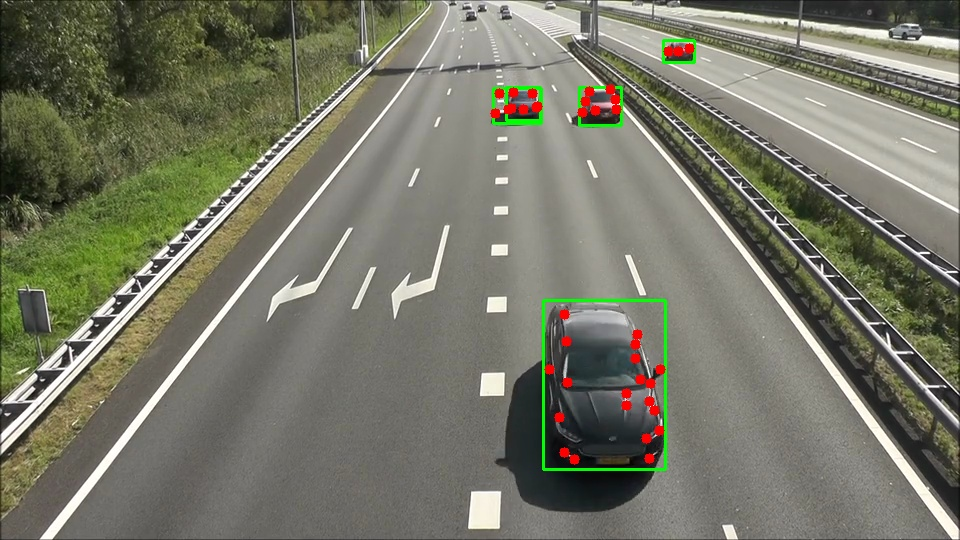


Finished processing. Frames processed: 100

Video capture released.


In [44]:
input_video_path = 'cars_road.mp4' 
# Or use 'cars_road_2.mp4'

if not os.path.exists(input_video_path):
    print(f"Error: Video file not found at {input_video_path}")
elif model is None: # Check if model loaded from Cell 6
    print("Error: YOLO model failed to load. Cannot process video.")
else:
    cap = cv2.VideoCapture(input_video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video file {input_video_path}")
    else:
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f"Video loaded: {input_video_path} ({frame_width}x{frame_height} @ {fps:.2f} FPS, {total_frames} frames)")
        
        # Define the placeholder K based on video dimensions if not already done in Cell 4
        if K is None: 
             # Rough assumption: fx = fy = width, cx = width/2, cy = height/2
             fx = frame_width 
             fy = frame_width # Often fx approx fy
             cx = frame_width / 2.0
             cy = frame_height / 2.0
             K = np.array([[fx, 0, cx],
                           [0, fy, cy],
                           [0,  0,  1]], dtype=np.float32)
             print("\nDefined placeholder Camera Matrix K:")
             print(K)

        frame_count = 0
        max_frames_to_process = 100 # Limit processing for faster testing, adjust as needed
        display_output = True # Set to False to disable image display (runs faster)

        while True:
            ret, frame = cap.read()
            # Stop if no frame or max frames reached
            if not ret or (max_frames_to_process is not None and frame_count >= max_frames_to_process):
                print(f"\nFinished processing. Frames processed: {frame_count}")
                break

            # --- Core Logic ---
            vehicle_boxes, features_per_vehicle = detect_vehicle_features(frame, model)
            # -----------------
            
            # Optional: Print progress
            print(f'\rProcessing frame {frame_count+1}/{total_frames if max_frames_to_process is None else max_frames_to_process}... Found {len(vehicle_boxes)} vehicles.', end='')

            # --- Visualization (Optional) ---
            if display_output:
                display_frame = frame.copy()
                # Draw vehicle bounding boxes
                for box in vehicle_boxes:
                    cv2.rectangle(display_frame, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2) # Green box
                
                # Draw detected 'feature' points (currently center of bottom edge)
                for vehicle_features in features_per_vehicle:
                     for point in vehicle_features: # Draw each feature point for the vehicle
                          cv2.circle(display_frame, tuple(map(int, point)), 5, (0, 0, 255), -1) # Red circle 

                # Display the frame in the notebook
                _, buffer = cv2.imencode('.jpg', display_frame)
                clear_output(wait=True) # Clear previous frame's output
                display(Image(data=buffer.tobytes()))
                time.sleep(0.05) # Add a small delay so it's not too fast
            # ---------------------------
            
            frame_count += 1

        cap.release()
        print("\nVideo capture released.")
        # cv2.destroyAllWindows() # Usually not needed/problematic in notebooks

## Phase 2
track detected features across consecutive frames using the Kanade-Lucas-Tomasi (KLT) optical flow algorithm.

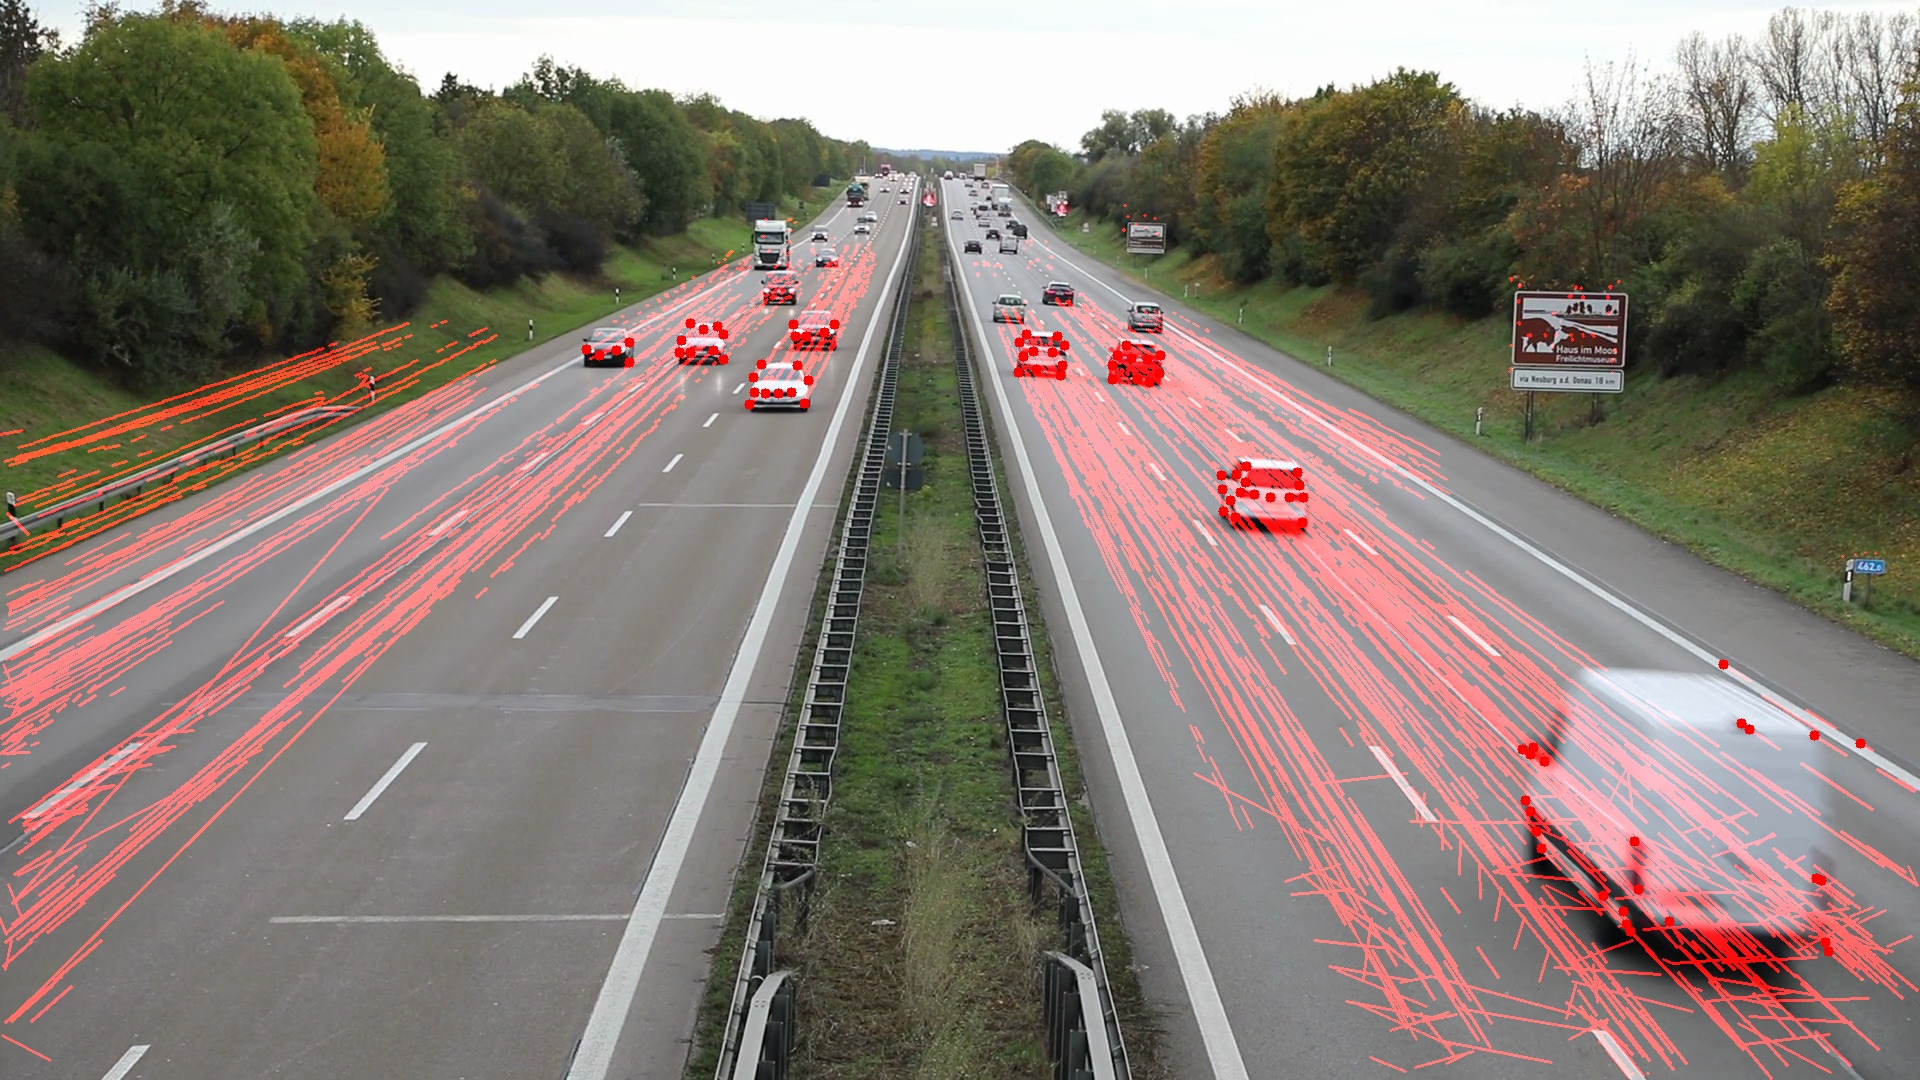

Processing frame 100/100... Found 9 vehicles. Tracking 106 points.
Finished processing. Frames processed: 100

Video capture released.


In [48]:
# --- Parameters for KLT Optical Flow ---
# You might need to tune these
lk_params = dict( winSize  = (15, 15),  # Size of the search window at each pyramid level
                  maxLevel = 2,         # 0-based maximal pyramid level number; if set to 0, pyramids are not used (single level), if set to 1, two levels are used, etc.
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)) # Termination criteria for the iterative search algorithm.
# ----------------------------------------

# --- Initialization for Tracking ---
prev_gray = None
# Store features detected in the *previous* frame. KLT needs shape (N, 1, 2)
# We'll store features from *all* vehicles flatly and remember which feature belongs to which track ID.
prev_features_flat = None
# Keep track of the original bounding box index for each feature point
feature_box_indices = []
# Assign a unique ID and color to each *tracked vehicle* (not each point)
track_id_counter = 0
active_tracks = {} # Dictionary to store track info: {track_id: {'box': [], 'features': [], 'color': (), 'last_seen': frame_count}}
# ----------------------------------


# --- Main Video Processing ---
input_video_path = 'cars_road_3.mp4'
# Or use 'cars_road_2.mp4'

if not os.path.exists(input_video_path):
    print(f"Error: Video file not found at {input_video_path}")
    # Handle error appropriately, e.g., exit or raise exception
else:
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {input_video_path}")
        # Handle error
    else:
        # Get video properties
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f"Video loaded: {frame_width}x{frame_height} @ {fps:.2f} FPS, {total_frames} frames.")

        # --- Define Camera Matrix K ---
        # If you have actual calibration data, load it here.
        # Otherwise, use the placeholder based on video dimensions.
        if 'K' not in locals() or K is None: # Check if K was defined earlier or needs defining
             # Rough assumption: fx = fy = width, cx = width/2, cy = height/2
             fx = frame_width
             fy = frame_width # Often fx approx fy
             cx = frame_width / 2.0
             cy = frame_height / 2.0
             K = np.array([[fx, 0, cx],
                           [0, fy, cy],
                           [0,  0,  1]], dtype=np.float32)
             print("\nDefined placeholder Camera Matrix K:")
             print(K)
        # ------------------------------

        frame_count = 0
        max_frames_to_process = 100 # Limit processing for faster testing, adjust as needed
        display_output = True # Set to False to disable image display (runs faster)

        # --- Create a mask image for drawing tracks ---
        # Initialize it here so it persists across frames
        track_mask = np.zeros((frame_height, frame_width, 3), dtype=np.uint8)
        # ---------------------------------------------

        while True:
            ret, frame = cap.read()
            # Stop if no frame or max frames reached
            if not ret or (max_frames_to_process is not None and frame_count >= max_frames_to_process):
                print(f"\nFinished processing. Frames processed: {frame_count}")
                break

            # Convert current frame to grayscale
            current_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # --- Feature Detection (Runs every frame for now) ---
            # Detect vehicles and their potential Shi-Tomasi features in the current frame
            current_vehicle_boxes, current_features_per_vehicle = detect_vehicle_features(frame, model)
            # Flatten the features for KLT input and keep track of box indices
            current_features_flat_list = []
            current_feature_box_indices = []
            for i, features in enumerate(current_features_per_vehicle):
                for feature in features:
                    current_features_flat_list.append(feature)
                    current_feature_box_indices.append(i) # Store the index of the vehicle box this feature belongs to

            # Convert to NumPy array with the shape KLT expects: (N, 1, 2)
            current_features_flat = np.array(current_features_flat_list, dtype=np.float32).reshape(-1, 1, 2)
            # -----------------------------------------------------

            # --- KLT Tracking ---
            tracked_features_new = [] # Will store successfully tracked features in current frame
            tracked_features_old = [] # Will store corresponding features from previous frame
            tracked_box_indices = []  # Indices linking tracked features back to boxes from *previous* frame

            if prev_gray is not None and prev_features_flat is not None and prev_features_flat.shape[0] > 0:
                # Calculate optical flow
                new_positions, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, current_gray, prev_features_flat, None, **lk_params)

                # Select good points (status == 1)
                if new_positions is not None:
                   good_new = new_positions[status == 1]
                   good_old = prev_features_flat[status == 1]
                   good_indices = np.array(feature_box_indices)[status.flatten() == 1] # Get box indices for good points

                   tracked_features_new = good_new
                   tracked_features_old = good_old
                   tracked_box_indices = good_indices # We know which *previous* box these tracked points belonged to

            # --- Visualization ---
            display_frame = frame.copy()
            if display_output:
                # Draw current vehicle bounding boxes (optional, maybe confusing with tracks)
                # for box in current_vehicle_boxes:
                #     cv2.rectangle(display_frame, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 1) # Thin green box

                # Draw the tracks
                for i, (new, old) in enumerate(zip(tracked_features_new, tracked_features_old)):
                    a, b = new.ravel().astype(int)
                    c, d = old.ravel().astype(int)
                    # Draw the line segment for the track in this frame
                    # Let's use a fixed color for now, improvement could be track-specific colors
                    color = (0, 0, 255) # Red lines for tracks
                    cv2.line(track_mask, (a, b), (c, d), color, 2)
                    # Draw the current point of the track
                    cv2.circle(display_frame, (a, b), 5, color, -1)

                # Add the track mask to the display frame
                display_frame = cv2.add(display_frame, track_mask)

                # Display the frame in the notebook
                _, buffer = cv2.imencode('.jpg', display_frame)
                clear_output(wait=True) # Clear previous frame's output
                display(Image(data=buffer.tobytes()))
                # time.sleep(0.05) # Adjust delay if needed
            # --------------------

            # --- Update State for Next Iteration ---
            prev_gray = current_gray.copy()
            # The features detected in *this* frame become the previous features for the *next* frame
            prev_features_flat = current_features_flat
            feature_box_indices = current_feature_box_indices # Remember which box these features belong to
            # --------------------------------------

            # Optional: Print progress
            print(f'\rProcessing frame {frame_count+1}/{total_frames if max_frames_to_process is None else max_frames_to_process}... Found {len(current_vehicle_boxes)} vehicles. Tracking {len(tracked_features_new)} points.', end='')

            frame_count += 1

        cap.release()
        print("\nVideo capture released.")
        # cv2.destroyAllWindows() # Usually not needed/problematic in notebooks

## Phase 3
incorporate the necessary history tracking and the direction comparison

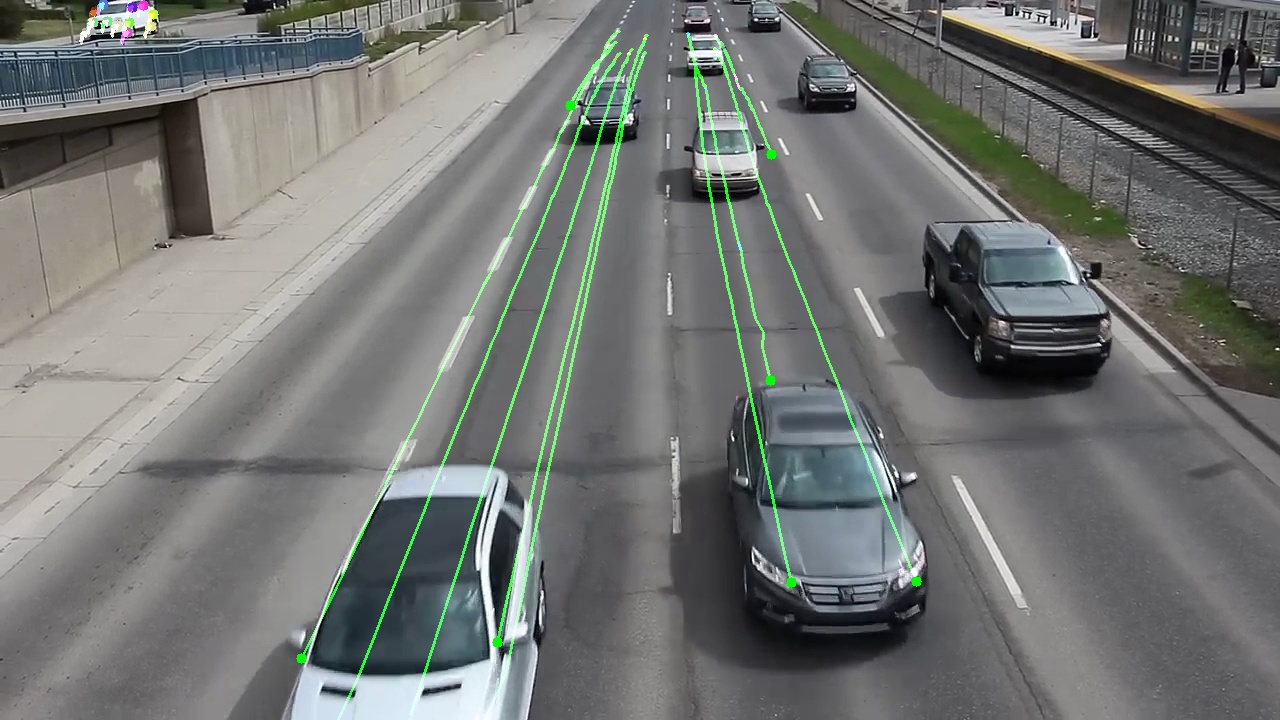

Processing frame 100/100... Tracking 19 points. Consistent: 7
Finished processing. Frames processed: 100

Video capture released.


In [52]:
# --- Parameters for KLT Optical Flow ---
# You might need to tune these
lk_params = dict( winSize  = (21, 21),  # Increased window size for potentially better tracking
                  maxLevel = 3,         # Increased max level
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# --- Parameters for Track Consistency ---
from collections import deque
max_track_length = 10 # Keep the last N points for consistency check
consistency_threshold = 0.90 # Cosine similarity threshold

# --- Initialization ---
input_video_path = './cars_road.mp4' # Or use 'cars_road_2.mp4'
active_tracks = {} # Dictionary to store active tracks: { track_id: {'points': deque, 'color': tuple, 'consistent': bool, 'feature_id': int} }
track_id_counter = 0
prev_gray = None
prev_features_klt = np.array([], dtype=np.float32).reshape(0, 1, 2) # Ensure it's initialized correctly
first_frame = True

# --- Option to limit processing ---
max_frames_to_process = 100 # Set to None to process the whole video
display_output = True      # Set to False to run without displaying frames (faster)

# --- NEW: Options for Visualization ---
# show_initial_bboxes = True # Option from previous cell logic, not directly used here unless integrated
show_corner_points = True  # Draw the currently tracked corner points
# ------------------------------------

# --- NEW: Variables to store the last good pair for Fundamental Matrix ---
last_good_old = None
last_good_new = None
last_frame_prev = None
last_frame_current = None
prev_frame_color = None # Initialize prev_frame_color for storing the frame corresponding to prev_gray
# --------------------------------------------------------------------

if not os.path.exists(input_video_path):
    print(f"Error: Video file not found at {input_video_path}")
elif model is None:
     print("Error: YOLO model not loaded successfully. Cannot proceed with feature detection.")
else:
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {input_video_path}")
    else:
        # --- Get Video Properties & Define Placeholder K (if not already defined) ---
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)

        # Define K if it wasn't defined earlier or needs redefining
        if K is None:
             fx = fy = frame_width # Simple assumptions
             cx = frame_width / 2.0
             cy = frame_height / 2.0
             K = np.array([[fx, 0, cx],
                           [0, fy, cy],
                           [0,  0,  1]], dtype=np.float32)
             print("\nDefined placeholder Camera Matrix K for KLT cell:")
             print(K)
        # -----------------------------------------------------------------

        frame_count = 0
        track_mask = None # Initialize mask for drawing tracks

        while True:
            ret, frame = cap.read()
            # Stop if no frame or max frames reached
            if not ret or (max_frames_to_process is not None and frame_count >= max_frames_to_process):
                print(f"\nFinished processing. Frames processed: {frame_count}")
                break

            current_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Initialize track mask on first frame
            if track_mask is None:
                 track_mask = np.zeros_like(frame)

            # --- Feature Detection (Only on first frame for this example) ---
            if first_frame:
                # --- Initial Detection in the First Frame ---
                vehicle_boxes, features_per_vehicle = detect_vehicle_features(frame, model)
                print(f"Frame 1: Detected {len(vehicle_boxes)} vehicles.")
                if features_per_vehicle:
                    # Flatten features and assign initial track IDs
                    temp_features = []
                    for features in features_per_vehicle:
                        if features is not None: # Check if features were found for this vehicle
                            for corner in features:
                                temp_features.append(corner)
                                # Initialize new track
                                track_id = track_id_counter
                                active_tracks[track_id] = {
                                    'points': deque(maxlen=max_track_length),
                                    'color': (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)),
                                    'consistent': False,
                                    'feature_id': track_id
                                }
                                active_tracks[track_id]['points'].append(corner.reshape(1, 2)) # Add first point
                                track_id_counter += 1

                    if temp_features:
                        prev_features_klt = np.array(temp_features, dtype=np.float32).reshape(-1, 1, 2)
                        print(f"Frame 1: Initialized {len(prev_features_klt)} tracks.")
                    else:
                        prev_features_klt = np.array([], dtype=np.float32).reshape(0, 1, 2)
                        print("Frame 1: No features found to initialize tracks.")

                else: # No vehicles detected
                    prev_features_klt = np.array([], dtype=np.float32).reshape(0, 1, 2)
                    print("Frame 1: No vehicles detected.")

                prev_gray = current_gray.copy()
                prev_frame_color = frame.copy() # Store the color frame for the first set of features
                first_frame = False
                # Create a new track mask for the fresh start
                track_mask = np.zeros_like(frame)
                # --------------------------------------------

            # --- KLT Tracking (Subsequent frames) ---
            elif prev_features_klt.size > 0:
                # Calculate optical flow
                next_features_klt, status, err = cv2.calcOpticalFlowPyrLK(
                    prev_gray, current_gray, prev_features_klt, None, **lk_params)

                # Filter out points that were not tracked successfully
                if next_features_klt is not None and status is not None:
                    # Ensure status is boolean for indexing
                    status_bool = status.ravel() == 1
                    good_new = next_features_klt[status_bool]
                    good_old = prev_features_klt[status_bool]
                    # Get IDs of successfully tracked features, careful with indexing
                    original_indices = np.where(status_bool)[0]
                    tracked_feature_ids = [list(active_tracks.keys())[idx] for idx in original_indices if idx < len(active_tracks)]

                else:
                    good_new = np.array([])
                    good_old = np.array([])
                    tracked_feature_ids = []

                # --- Store Last Good Pair for Fundamental Matrix Estimation ---
                if good_new is not None and len(good_new) >= 8: # Need at least 8 points
                    # Check if prev_frame_color exists (it should after the first frame)
                    if prev_frame_color is not None:
                        last_good_old = good_old.copy()
                        last_good_new = good_new.copy()
                        # Store the color frames corresponding to the points
                        last_frame_prev = prev_frame_color.copy()
                        last_frame_current = frame.copy()
                # -------------------------------------------------------------

                # --- Update Active Tracks & Check Consistency ---
                new_active_tracks = {}
                kept_features_list = [] # Store features to keep for the next KLT iteration

                current_track_keys = list(active_tracks.keys()) # Get keys before iteration

                for i, original_index in enumerate(original_indices):
                     # Check if the original index is valid for the current track keys
                     if original_index < len(current_track_keys):
                        track_id = current_track_keys[original_index]
                        if track_id in active_tracks: # Double check if track still exists
                            track_data = active_tracks[track_id]
                            new_point = good_new[i].reshape(1, 2)
                            # old_point = good_old[i].reshape(1, 2) # Not directly needed here

                            track_data['points'].append(new_point) # Add current point

                            # Check consistency if enough points are available
                            if len(track_data['points']) >= 3:
                                p3 = track_data['points'][-1][0] # Current
                                p2 = track_data['points'][-2][0] # Previous
                                p1 = track_data['points'][-3][0] # Previous-previous
                                v1 = p2 - p1
                                v2 = p3 - p2
                                norm_v1 = np.linalg.norm(v1)
                                norm_v2 = np.linalg.norm(v2)
                                if norm_v1 > 1e-6 and norm_v2 > 1e-6:
                                    cosine_sim = np.dot(v1 / norm_v1, v2 / norm_v2)
                                    track_data['consistent'] = cosine_sim >= consistency_threshold
                                else:
                                    track_data['consistent'] = False
                            else:
                                track_data['consistent'] = False

                            new_active_tracks[track_id] = track_data
                            kept_features_list.append(new_point) # Keep this feature for next KLT input

                active_tracks = new_active_tracks # Update the dictionary

                # Update features for the next iteration
                if kept_features_list:
                   prev_features_klt = np.array(kept_features_list, dtype=np.float32).reshape(-1, 1, 2)
                else:
                   prev_features_klt = np.array([], dtype=np.float32).reshape(0, 1, 2) # Handle case where all tracks are lost


            # --- (Optional) Add logic here to re-detect features if len(active_tracks) is too low ---
            # if len(active_tracks) < min_features_threshold:
            #    # Detect new features (avoiding existing tracked areas?) and add them
            #    pass

            # --- Visualization ---
            display_frame = frame.copy()
            if display_output:
                # Draw the tracks
                for track_id, track_data in active_tracks.items():
                    points_history = list(track_data['points'])
                    color = (0, 255, 0) if track_data['consistent'] else track_data['color'] # Green if consistent

                    # Draw lines connecting points in the history
                    for i in range(1, len(points_history)):
                        # Check if points are valid before drawing
                        if points_history[i-1] is not None and points_history[i] is not None:
                           pt1 = tuple(points_history[i-1][0].astype(int))
                           pt2 = tuple(points_history[i][0].astype(int))
                           cv2.line(track_mask, pt1, pt2, color, 2)

                    # Draw the current point (if enabled and point exists)
                    if show_corner_points and points_history and points_history[-1] is not None:
                        current_point = tuple(points_history[-1][0].astype(int))
                        cv2.circle(display_frame, current_point, 5, color, -1)

                # Add the track mask to the display frame
                display_frame = cv2.add(display_frame, track_mask)

                # Display the frame in the notebook
                _, buffer = cv2.imencode('.jpg', display_frame)
                clear_output(wait=True) # Clear previous frame's output
                display(Image(data=buffer.tobytes()))
                # time.sleep(0.05) # Adjust delay if needed
            # --------------------

            # --- Update State for Next Iteration ---
            prev_frame_color = frame.copy() # Update the previous color frame for the next iteration
            prev_gray = current_gray.copy()
            # prev_features_klt is updated inside the tracking logic
            # --------------------------------------

            # Optional: Print progress
            num_consistent = sum(1 for t in active_tracks.values() if t['consistent'])
            print(f'\rProcessing frame {frame_count+1}/{total_frames if max_frames_to_process is None else max_frames_to_process}... Tracking {len(active_tracks)} points. Consistent: {num_consistent}', end='')

            frame_count += 1

        cap.release()
        print("\nVideo capture released.")
        # cv2.destroyAllWindows() # Usually not needed/problematic in notebooks


Estimating Fundamental Matrix using 19 point pairs.

Fundamental Matrix (F):
[[-5.4241e-06    0.020247      2.9881]
 [  -0.020341  -0.0001448      16.069]
 [    -2.9941     -16.065           1]]

Number of inliers: 19


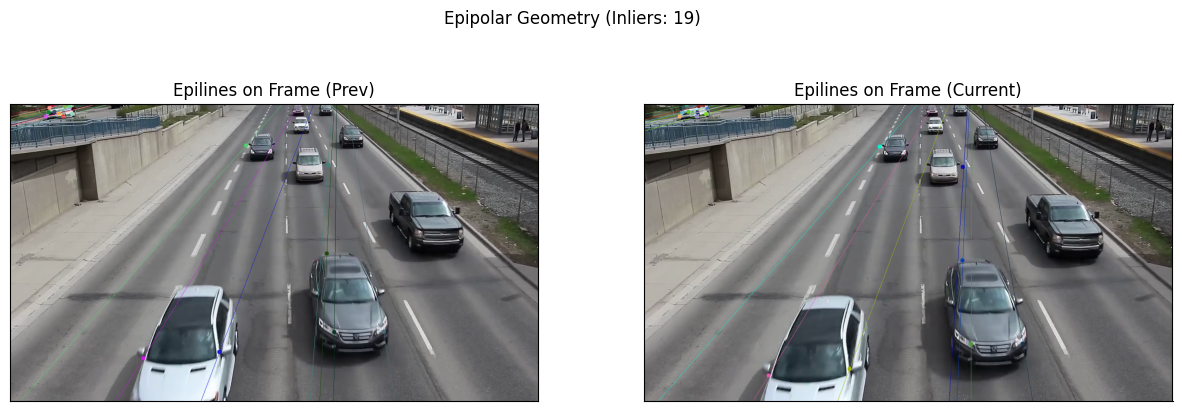

Saved epipolar line visualization to ./images/phase3_fundamental_matrix_epilines.png


In [53]:
# --- Phase 3: Fundamental Matrix Estimation and Visualization ---
import matplotlib.pyplot as plt

# Function to draw epilines
def drawlines(img1, img2, lines, pts1, pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1.shape[:2] # Get rows and columns from the shape
    # Ensure img1 is color for drawing lines
    if len(img1.shape) == 2:
        img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    # Ensure img2 is color
    if len(img2.shape) == 2:
        img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    # Iterate over lines and points
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]]) # Calculate start point of the line (x=0)
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]]) # Calculate end point of the line (x=c)
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1) # Draw line on img1
        # Draw corresponding points on both images
        pt1_int = tuple(map(int, pt1[0])) # Ensure pt1 is tuple of ints
        pt2_int = tuple(map(int, pt2[0])) # Ensure pt2 is tuple of ints
        img1 = cv2.circle(img1, pt1_int, 5, color, -1)
        img2 = cv2.circle(img2, pt2_int, 5, color, -1)
    return img1, img2

# Check if we have stored points and frames from the KLT tracking
if last_good_old is not None and last_good_new is not None and \
   last_frame_prev is not None and last_frame_current is not None:

    print(f"Estimating Fundamental Matrix using {len(last_good_old)} point pairs.")

    # Ensure points are in the correct format (float32)
    pts1 = np.float32(last_good_old)
    pts2 = np.float32(last_good_new)

    # Estimate Fundamental Matrix using RANSAC
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

    if F is None:
        print("Fundamental Matrix estimation failed (F is None). Not enough inliers?")
    else:
        print("\nFundamental Matrix (F):")
        print(F)

        # Select only inlier points (points consistent with the estimated F)
        pts1_inliers = pts1[mask.ravel() == 1]
        pts2_inliers = pts2[mask.ravel() == 1]
        print(f"\nNumber of inliers: {len(pts1_inliers)}")

        if len(pts1_inliers) < 8:
             print("Warning: Less than 8 inliers found. Visualization might be unreliable.")

        if len(pts1_inliers) > 0: # Proceed only if inliers exist
            # --- Visualization of Epipolar Lines ---
            # Find epilines corresponding to points in right image (img2) and draw them on left image (img1)
            lines1 = cv2.computeCorrespondEpilines(pts2_inliers.reshape(-1, 1, 2), 2, F)
            lines1 = lines1.reshape(-1, 3)
            img5, img6 = drawlines(last_frame_prev.copy(), last_frame_current.copy(), lines1, pts1_inliers, pts2_inliers)

            # Find epilines corresponding to points in left image (img1) and draw them on right image (img2)
            lines2 = cv2.computeCorrespondEpilines(pts1_inliers.reshape(-1, 1, 2), 1, F)
            lines2 = lines2.reshape(-1, 3)
            img3, img4 = drawlines(last_frame_current.copy(), last_frame_prev.copy(), lines2, pts2_inliers, pts1_inliers)

            # Display the images with epilines
            plt.figure(figsize=(15, 5))
            plt.subplot(121), plt.imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
            plt.title('Epilines on Frame (Prev)'), plt.xticks([]), plt.yticks([])
            plt.subplot(122), plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
            plt.title('Epilines on Frame (Current)'), plt.xticks([]), plt.yticks([])
            plt.suptitle(f'Epipolar Geometry (Inliers: {len(pts1_inliers)})')
            plt.show()

            # --- Optional: Save the output image ---
            # Combine the two images for saving maybe?
            combined_img = np.concatenate((img5, img3), axis=1)
            output_filename = './images/phase3_fundamental_matrix_epilines.png'
            try:
                 # Ensure the images directory exists (though we created it earlier)
                 os.makedirs('./images', exist_ok=True)
                 cv2.imwrite(output_filename, combined_img)
                 print(f"Saved epipolar line visualization to {output_filename}")
            except Exception as e:
                 print(f"Error saving image: {e}")
            # ----------------------------------------

        else:
            print("No inliers found after RANSAC. Cannot draw epipolar lines.")

else:
    print("No suitable point correspondences found or stored from the KLT tracking phase.")
    print("Ensure the KLT tracking cell ran successfully and found/tracked >= 8 points in at least one frame pair.")
